# Group 15: Hyperparameter tuning for transfer learning

In [1]:
from main import *
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import os 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [4]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


## Function to load pretrained vgg16 model and truncate it to a given layer number. Set a fixed number of layers to non trainable. This is used to find the best combination to do transfer learning with VGG16 models. We run 3 combinations
- One with truncated shallow network
- One where we finetune the shallow network
- One in which we just finetune the whole network and keep a fixed number of layers as frozen in the beginning

In [5]:
def shallow_vgg16(layer_indices, allow_train=False, full_network=False):
    
    results = []
    for layer_num in layer_indices:
        print("Current layer: ", layer_num)
        input_shape = (30, 30, 1)
        input_layer = layers.Input(shape=input_shape)
    
        # Convert image to rgb and resize to 32x32
        rgb_layer = layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x), output_shape=(30, 30, 3))(input_layer)
        resized_layer = layers.Lambda(lambda x: tf.image.resize(x, (32, 32)),output_shape=(32, 32, 3))(rgb_layer)
    
        # load the VGG16 model without the top FC layer
        vgg_model = VGG16(include_top=False, input_shape=(32, 32, 3))

        if full_network:
            if "pool" in vgg_model.layers[layer_num].name:
                print("skipping pool layer")
                continue
        
            # set layers as trainable
            for i,layer in enumerate(vgg_model.layers[1:]):
        
                if i<layer_num:
                    layer.trainable = False
                    print(layer.name, "Is not trainable")
                else:
                    print(layer.name, "Is trainable")
                    layer.trainable = True
        
            # add flatten layer
            flat = layers.Flatten()(vgg_model(resized_layer))
    
        else:
            truncated_vgg16 = Model(inputs=vgg_model.input, outputs=vgg_model.layers[layer_num].output)
        
            truncated_vgg16.summary()
    
            if not allow_train:
                # make the layers non trainable (i.e freeze the layers)
                for i,layer in enumerate(truncated_vgg16.layers[1:]):
                    layer.trainable = False
                    print(i, layer.name, layer.trainable)
                
        
            # add flatten layer
            flat = layers.Flatten()(truncated_vgg16(resized_layer))
    
        # add fully connected layer
        fc = layers.Dense(128, activation='relu')(flat)
    
        # Add output layer 
        output = layers.Dense(4, activation='softmax')(fc)
    
        # define model input and output
        model = Model(inputs=input_layer, outputs=output)
    
        # summarize
        model.summary()
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        # add early stopping       
        early_stopping = EarlyStopping(monitor= 'val_loss', patience = 4, start_from_epoch= 8, restore_best_weights= True)
    
        # model training
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=30,
            verbose=1,
            callbacks=[early_stopping] 
        )
        # evaluate and save results
        performance = model.evaluate(X_val, y_val)
        results.append((layer_num, performance))

    return results



In [6]:
def plot_results(results):
  accuracy_list = []
  num_layers_list = []
  for itr, result in results: 
      val_loss, val_accuracy = result
      accuracy_list.append(val_accuracy)
      num_layers_list.append(itr)

  plt.figure(figsize=(7, 3))
  sns.set_theme()
  conv_blocks = [i for i in range(len(num_layers_list))]
  sns.lineplot(x=conv_blocks, y=accuracy_list, marker='o', color='b', markersize=10, linewidth=2.5, label='Accuracy')
  plt.title('Validation Accuracy vs Num of Conv Blocks')
  plt.xlabel('Number of Conv Blocks')
  plt.xticks(conv_blocks)
  plt.ylabel('Validation Accuracy')
  plt.grid(True)
  plt.show()



## Train shallow network without any finetuning truncate at layer 3, 6, 10, 14 and 18

In [7]:
shallow_models_results = shallow_vgg16([3,6,10,14,18], allow_train=False)



Current layer:  3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 38,720 (151.25 KB)

 Non-trainable params: 0 (0.00 B)

0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 16, 16, 64)     │        38,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,136,516 (8.15 MB)

 Trainable params: 2,097,796 (8.00 MB)

 Non-trainable params: 38,720 (151.25 KB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4060 - loss: 24.9776 - val_accuracy: 0.5670 - val_loss: 2.7804
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6582 - loss: 1.4939 - val_accuracy: 0.6540 - val_loss: 1.8095
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7074 - loss: 1.3384 - val_accuracy: 0.6630 - val_loss: 1.5304
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7080 - loss: 1.3220 - val_accuracy: 0.6929 - val_loss: 1.3834
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7900 - loss: 0.7744 - val_accuracy: 0.7482 - val_loss: 0.9807
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7832 - loss: 0.6857 - val_accuracy: 0.7156 - val_loss: 1.0286
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7743 - loss: 0.7873 - val_accuracy: 0.6042 - val_loss: 1.7648
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8057 - loss: 0.6520 - val_acc

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,160 (1016.25 KB)

 Trainable params: 260,160 (1016.25 KB)

 Non-trainable params: 0 (0.00 B)

0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False
3 block2_conv1 False
4 block2_conv2 False
5 block2_pool False


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 8, 8, 128)      │       260,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,380 (4.99 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.4738 - loss: 18.0550 - val_accuracy: 0.6268 - val_loss: 2.4750
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7375 - loss: 1.5761 - val_accuracy: 0.7228 - val_loss: 1.5612
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7812 - loss: 1.0313 - val_accuracy: 0.7627 - val_loss: 1.0785
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8478 - loss: 0.5731 - val_accuracy: 0.6803 - val_loss: 1.9077
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8184 - loss: 0.7695 - val_accuracy: 0.6975 - val_loss: 2.6484
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8433 - loss: 0.6541 - val_accuracy: 0.8062 - val_loss: 0.8998
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8748 - loss: 0.5696 - val_accuracy: 0.7799 - val_loss: 1.0239
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8849 - loss: 0.3665 - val_acc

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False
3 block2_conv1 False
4 block2_conv2 False
5 block2_pool False
6 block3_conv1 False
7 block3_conv2 False
8 block3_conv3 False
9 block3_pool False


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 4, 4, 256)      │     1,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,420 (8.62 MB)

 Trainable params: 524,932 (2.00 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.5301 - loss: 10.7549 - val_accuracy: 0.6341 - val_loss: 1.9708
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7764 - loss: 0.8611 - val_accuracy: 0.6875 - val_loss: 1.4939
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.7603 - loss: 0.8814 - val_accuracy: 0.7609 - val_loss: 1.0564
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8283 - loss: 0.5246 - val_accuracy: 0.7065 - val_loss: 1.4640
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7996 - loss: 0.7278 - val_accuracy: 0.7699 - val_loss: 0.8661
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8452 - loss: 0.4405 - val_accuracy: 0.7880 - val_loss: 0.8065
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8679 - loss: 0.4043 - val_accuracy: 0.7772 - val_loss: 0.9821
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.8659 - loss: 

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False
3 block2_conv1 False
4 block2_conv2 False
5 block2_pool False
6 block3_conv1 False
7 block3_conv2 False
8 block3_conv3 False
9 block3_pool False
10 block4_conv1 False
11 block4_conv2 False
12 block4_conv3 False
13 block4_pool False


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 2, 2, 512)      │     7,635,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,898,052 (30.13 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.5600 - loss: 1.6552 - val_accuracy: 0.7056 - val_loss: 0.8071
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.7496 - loss: 0.6410 - val_accuracy: 0.7482 - val_loss: 0.6825
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.7873 - loss: 0.5430 - val_accuracy: 0.7201 - val_loss: 0.7278
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.8079 - loss: 0.4871 - val_accuracy: 0.7636 - val_loss: 0.6275
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.8383 - loss: 0.4344 - val_accuracy: 0.7781 - val_loss: 0.6539
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.8331 - loss: 0.4320 - val_accuracy: 0.7591 - val_loss: 0.7095
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.8236 - loss: 0.4366 - val_accuracy: 0.7790 - val_loss: 0.6273
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.8471 - loss: 0

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

0 block1_conv1 False
1 block1_conv2 False
2 block1_pool False
3 block2_conv1 False
4 block2_conv2 False
5 block2_pool False
6 block3_conv1 False
7 block3_conv2 False
8 block3_conv3 False
9 block3_pool False
10 block4_conv1 False
11 block4_conv2 False
12 block4_conv3 False
13 block4_pool False
14 block5_conv1 False
15 block5_conv2 False
16 block5_conv3 False
17 block5_pool False


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 0.4910 - loss: 1.1628 - val_accuracy: 0.6522 - val_loss: 0.8943
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - accuracy: 0.6452 - loss: 0.8695 - val_accuracy: 0.6739 - val_loss: 0.8332
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.6642 - loss: 0.8047 - val_accuracy: 0.6739 - val_loss: 0.8102
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.6804 - loss: 0.7596 - val_accuracy: 0.6884 - val_loss: 0.7993
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 33s 227ms/step - accuracy: 0.6893 - loss: 0.7428 - val_accuracy: 0.6975 - val_loss: 0.7794
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6995 - loss: 0.7214 - val_accuracy: 0.6911 - val_loss: 0.7718
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 54s 372ms/step - accuracy: 0.7061 - loss: 0.7016 - val_accuracy: 0.6866 - val_loss: 0.7765
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 51s 355ms/step - accuracy: 0.7150 - loss: 0

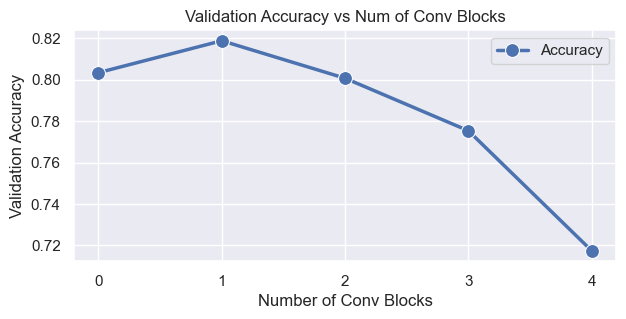

In [8]:
plot_results(shallow_models_results)


## Train shallow network with finetuning truncate at layer 3, 6, 10, 14 and 18

In [9]:
shallow_models_finetuned_results = shallow_vgg16([3,6,10,14,18], allow_train=True)


Current layer:  3


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 38,720 (151.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 16, 16, 64)     │        38,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,136,516 (8.15 MB)

 Trainable params: 2,136,516 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.4180 - loss: 17.7740 - val_accuracy: 0.7373 - val_loss: 0.7339
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.7715 - loss: 0.6252 - val_accuracy: 0.7926 - val_loss: 0.5685
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.8548 - loss: 0.4003 - val_accuracy: 0.7908 - val_loss: 0.5947
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 160ms/step - accuracy: 0.8837 - loss: 0.3058 - val_accuracy: 0.7726 - val_loss: 0.6687
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.9284 - loss: 0.2216 - val_accuracy: 0.8080 - val_loss: 0.6198
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9501 - loss: 0.1599 - val_accuracy: 0.8007 - val_loss: 0.6668
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.9630 - loss: 0.1185 - val_accuracy: 0.8043 - val_loss: 0.6297
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.9824 - loss: 

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,160 (1016.25 KB)

 Trainable params: 260,160 (1016.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_12 (Functional)      │ (None, 8, 8, 128)      │       260,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,380 (4.99 MB)

 Trainable params: 1,309,380 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 51s 329ms/step - accuracy: 0.3447 - loss: 11.9514 - val_accuracy: 0.5399 - val_loss: 1.0215
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.5723 - loss: 0.9977 - val_accuracy: 0.6504 - val_loss: 0.8469
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 0.6739 - loss: 0.7971 - val_accuracy: 0.7065 - val_loss: 0.7629
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.7046 - loss: 0.7187 - val_accuracy: 0.6476 - val_loss: 0.8843
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 91s 357ms/step - accuracy: 0.7271 - loss: 0.6948 - val_accuracy: 0.7192 - val_loss: 0.7012
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.7662 - loss: 0.5861 - val_accuracy: 0.7400 - val_loss: 0.6768
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 325ms/step - accuracy: 0.7662 - loss: 0.5922 - val_accuracy: 0.7464 - val_loss: 0.6284
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 334ms/step - accuracy: 0.7896 - loss: 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_15 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_14 (Functional)      │ (None, 4, 4, 256)      │     1,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,420 (8.62 MB)

 Trainable params: 2,260,420 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 102s 684ms/step - accuracy: 0.2729 - loss: 8.4596 - val_accuracy: 0.4438 - val_loss: 1.2074
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 569ms/step - accuracy: 0.5395 - loss: 1.0804 - val_accuracy: 0.6821 - val_loss: 0.8189
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.6968 - loss: 0.7700 - val_accuracy: 0.7373 - val_loss: 0.7131
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 582ms/step - accuracy: 0.7332 - loss: 0.6696 - val_accuracy: 0.7717 - val_loss: 0.6422
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 583ms/step - accuracy: 0.7630 - loss: 0.5954 - val_accuracy: 0.7400 - val_loss: 0.6258
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.7878 - loss: 0.5237 - val_accuracy: 0.7772 - val_loss: 0.5502
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.8051 - loss: 0.4798 - val_accuracy: 0.7844 - val_loss: 0.5409
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 581ms/step - accuracy: 0.8182 - loss: 

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_16 (Functional)      │ (None, 2, 2, 512)      │     7,635,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,898,052 (30.13 MB)

 Trainable params: 7,898,052 (30.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 134s 923ms/step - accuracy: 0.2698 - loss: 3.2037 - val_accuracy: 0.3605 - val_loss: 1.2595
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4239 - loss: 1.2165 - val_accuracy: 0.6096 - val_loss: 1.0181
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.6078 - loss: 0.9464 - val_accuracy: 0.6676 - val_loss: 0.8290
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6853 - loss: 0.7871 - val_accuracy: 0.7129 - val_loss: 0.7093
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.7461 - loss: 0.6594 - val_accuracy: 0.7690 - val_loss: 0.6092
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.7783 - loss: 0.5767 - val_accuracy: 0.7935 - val_loss: 0.5657
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7906 - loss: 0.5385 - val_accuracy: 0.7627 - val_loss: 0.6005
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8172 - loss: 0.4504 - val_a

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_18 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_19 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_18 (Functional)      │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 14,780,868 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 776ms/step - accuracy: 0.2885 - loss: 1.8751 - val_accuracy: 0.4810 - val_loss: 1.1745
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 102s 712ms/step - accuracy: 0.5641 - loss: 1.0416 - val_accuracy: 0.6078 - val_loss: 0.9472
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 102s 710ms/step - accuracy: 0.6126 - loss: 0.9526 - val_accuracy: 0.6504 - val_loss: 0.8356
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 97s 674ms/step - accuracy: 0.6354 - loss: 0.8754 - val_accuracy: 0.5951 - val_loss: 0.9097
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 97s 674ms/step - accuracy: 0.6742 - loss: 0.7947 - val_accuracy: 0.7138 - val_loss: 0.7428
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 95s 663ms/step - accuracy: 0.7199 - loss: 0.7227 - val_accuracy: 0.7554 - val_loss: 0.6868
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7243 - loss: 0.6884 - val_accuracy: 0.7645 - val_loss: 0.6061
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 1374s 10s/step - accuracy: 0.7605 - loss: 

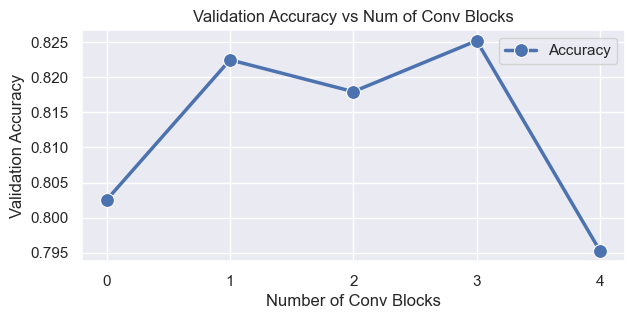

In [10]:
plot_results(shallow_models_finetuned_results)

## Train full network with finetuning freeze blocks before layer 5, 9 and 13 iteratively

In [11]:
full_model_results = shallow_vgg16([5,9,13], allow_train=True, full_network=True)


Current layer:  5
block1_conv1 Is not trainable
block1_conv2 Is not trainable
block1_pool Is not trainable
block2_conv1 Is not trainable
block2_conv2 Is not trainable
block2_pool Is trainable
block3_conv1 Is trainable
block3_conv2 Is trainable
block3_conv3 Is trainable
block3_pool Is trainable
block4_conv1 Is trainable
block4_conv2 Is trainable
block4_conv3 Is trainable
block4_pool Is trainable
block5_conv1 Is trainable
block5_conv2 Is trainable
block5_conv3 Is trainable
block5_pool Is trainable


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_20 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_21 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 14,520,708 (55.39 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 321ms/step - accuracy: 0.2682 - loss: 1.5946 - val_accuracy: 0.4393 - val_loss: 1.1784
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 319ms/step - accuracy: 0.4701 - loss: 1.1568 - val_accuracy: 0.5951 - val_loss: 0.9753
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 311ms/step - accuracy: 0.6056 - loss: 0.9702 - val_accuracy: 0.6422 - val_loss: 0.8901
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 310ms/step - accuracy: 0.6649 - loss: 0.8238 - val_accuracy: 0.7083 - val_loss: 0.7409
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 44s 307ms/step - accuracy: 0.7155 - loss: 0.6933 - val_accuracy: 0.6812 - val_loss: 0.8273
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 300ms/step - accuracy: 0.6956 - loss: 0.7137 - val_accuracy: 0.7038 - val_loss: 0.7048
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - accuracy: 0.7243 - loss: 0.6493 - val_accuracy: 0.7717 - val_loss: 0.6290
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.7524 - loss: 0

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_22 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_23 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 13,045,380 (49.76 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.3197 - loss: 1.3999 - val_accuracy: 0.6033 - val_loss: 1.1406
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6366 - loss: 0.8686 - val_accuracy: 0.6893 - val_loss: 0.7688
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6804 - loss: 0.7219 - val_accuracy: 0.6812 - val_loss: 0.7513
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6857 - loss: 0.6967 - val_accuracy: 0.6603 - val_loss: 0.7601
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7327 - loss: 0.6319 - val_accuracy: 0.7518 - val_loss: 0.6631
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7754 - loss: 0.5786 - val_accuracy: 0.7509 - val_loss: 0.7422
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7899 - loss: 0.5391 - val_accuracy: 0.7636 - val_loss: 0.6756
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7962 - loss: 0.5252 - val_accu

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_24 (Lambda)              │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_25 (Lambda)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 7,145,604 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 479ms/step - accuracy: 0.4065 - loss: 1.3404 - val_accuracy: 0.6748 - val_loss: 0.7715
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.6988 - loss: 0.7343 - val_accuracy: 0.7165 - val_loss: 0.7428
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 462ms/step - accuracy: 0.7491 - loss: 0.6400 - val_accuracy: 0.7699 - val_loss: 0.6382
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 55s 379ms/step - accuracy: 0.7771 - loss: 0.5497 - val_accuracy: 0.7464 - val_loss: 0.6689
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.8037 - loss: 0.4992 - val_accuracy: 0.7736 - val_loss: 0.6175
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 398ms/step - accuracy: 0.8262 - loss: 0.4519 - val_accuracy: 0.7264 - val_loss: 0.7095
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - accuracy: 0.8224 - loss: 0.4488 - val_accuracy: 0.7518 - val_loss: 0.7448
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 397ms/step - accuracy: 0.8424 - loss: 0

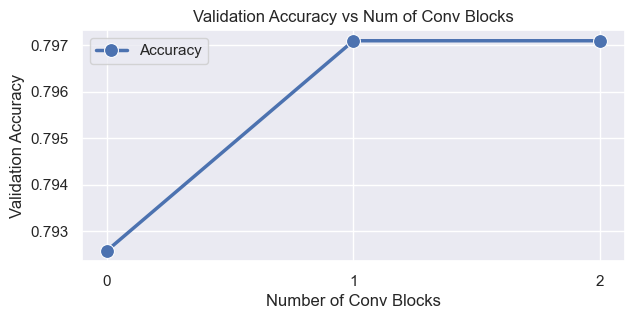

In [ ]:
plot_results(full_model_results)

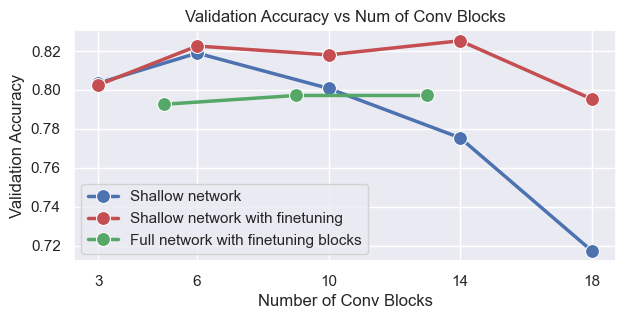

In [17]:
accuracy_list_1 = []
num_layers_list_1 = []
for itr, result in shallow_models_results: 
    val_loss, val_accuracy = result
    accuracy_list_1.append(val_accuracy)
    num_layers_list_1.append(itr)

accuracy_list_2 = []
num_layers_list_2 = []
for itr, result in shallow_models_finetuned_results: 
    val_loss, val_accuracy = result
    accuracy_list_2.append(val_accuracy)
    num_layers_list_2.append(itr)

accuracy_list_3 = []
num_layers_list_3 = []
for itr, result in full_model_results: 
    val_loss, val_accuracy = result
    accuracy_list_3.append(val_accuracy)
    num_layers_list_3.append(itr)

plt.figure(figsize=(7, 3))
sns.set_theme()
conv_blocks = [i+1 for i in range(len(num_layers_list_1))]
sns.lineplot(x=num_layers_list_1, y=accuracy_list_1, marker='o', color='b', markersize=10, linewidth=2.5, label='Shallow network ')
sns.lineplot(x=num_layers_list_2, y=accuracy_list_2, marker='o', color='r', markersize=10, linewidth=2.5, label='Shallow network with finetuning')
sns.lineplot(x=num_layers_list_3, y=accuracy_list_3, marker='o', color='g', markersize=10, linewidth=2.5, label='Full network with finetuning blocks')

plt.title('Validation Accuracy vs Num of Conv Blocks')
plt.xlabel('Number of Conv Blocks')
plt.xticks(num_layers_list_1)
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()